In [74]:
import MDAnalysis as mda
from MDAnalysis.transformations import unwrap, center_in_box
import os
import numpy as np
import freud
import matplotlib.pyplot as plt

In [75]:
lipids = 128

In [76]:
dir = "/home/gabriel/Dokumente/bachelor_thesis/dpd_simulation/lipid_self_assembly/"
top_file = os.path.join(dir, f"setup/lammps_{lipids}.data")
traj_file = os.path.join(dir, f"assembly/trajectories_{lipids}.lammpstrj")

Hier LAMMPS timestep eingeben

In [77]:
u = mda.Universe(top_file, format="DATA", atom_style = "id resid type charge x y z")
u.load_new(traj_file, format="LAMMPSDUMP", dt=0.01)

<Universe with 4608 atoms>

In [78]:
steps = 600000
timescale = 91.2 #ps
timestep = u.trajectory.dt
frames = len(u.trajectory)
time_per_frame = steps/frames*timestep*(timescale/1000) #ns
print(time_per_frame)

1.8179401993355484


## Unwrap molecules, no bonds over box edge

In [79]:
lipid_atoms = u.select_atoms(f"resid 1:{lipids}")

transforms = [unwrap(lipid_atoms), center_in_box(lipid_atoms,center="geometry")]
u.trajectory.add_transformations(*transforms)

## Contact number

In [80]:
def square_area(box_dims):

    box_dims_list = box_dims.tolist()
    index_double_occurence = [box_dims_list.count(x) for x in box_dims].index(2)

    assert index_double_occurence != None

    area = box_dims[index_double_occurence]**2

    return area

In [81]:
def contact_number(universe):

    contact_number = np.zeros(len(universe.trajectory))
    lipid_res = u.residues[:lipids]

    for frame_id, frame in enumerate(universe.trajectory):

        box_dims = universe.dimensions[:3]
        coms = np.array([res.atoms.center_of_mass() for res in lipid_res])

        dist_matrix = coms[:,None,:] - coms[None,:,:]
        dist_matrix = dist_matrix - box_dims * np.round(dist_matrix/box_dims)

        dists = np.linalg.norm(dist_matrix, axis=2)
        np.fill_diagonal(dists, np.inf)

        area = square_area(box_dims)

        apl = area/(lipids/2)
        cutoff = 2*np.sqrt(apl/np.pi)
        
        neighbor_per_lipid = (dists <= cutoff).sum(axis=1)
        contact_number[frame_id] = np.mean(neighbor_per_lipid)

    return contact_number

In [82]:
self_assembly_contact_number = contact_number(u)

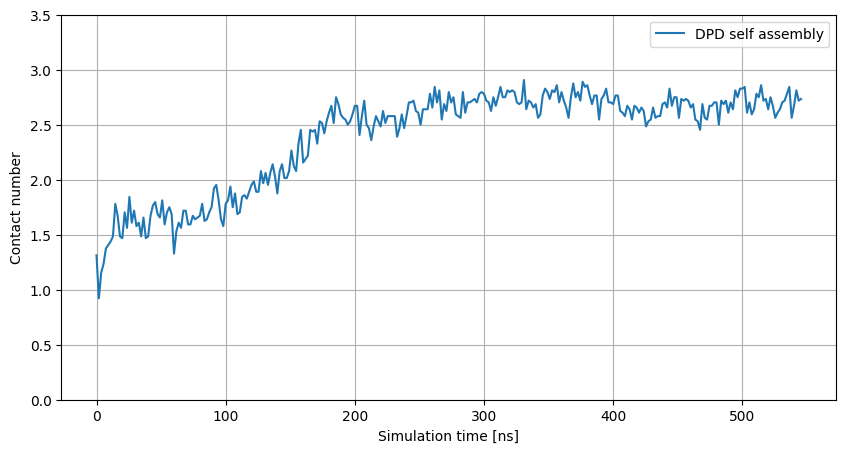

In [83]:
plt.figure(figsize=(10,5))

plt.plot(np.arange(len(self_assembly_contact_number))*time_per_frame,self_assembly_contact_number, label="DPD self assembly")
plt.xlabel("Simulation time [ns]")
plt.ylabel("Contact number")
plt.ylim((0,3.5))
plt.grid()
plt.legend()

## Nematic Order

In [84]:
nematic = freud.order.Nematic()

In [85]:
def neamtic_order(universe):

    s_values = np.zeros(len(universe.trajectory))
    directors = np.zeros((len(universe.trajectory), 3))

    lipid_res = u.residues[:lipids]

    for frame_id, frame in enumerate(universe.trajectory):


        orientations = np.zeros((len(lipid_res), 3))

        for mol_id, mol in enumerate(lipid_res):

            positions = mol.atoms.positions
            orientation_long = (positions[7] + positions[11])/2 - positions[0]
            orientations[mol_id] = orientation_long/np.linalg.norm(orientation_long)

        nematic.compute(orientations)

        s_values[frame_id] = nematic.order
        directors[frame_id] = nematic.director

    return s_values, directors

In [86]:
s_values, directors = neamtic_order(u)

Fill in correct values for frame flags

In [87]:
high_temp = 50
cool_down = 100
frame_axis = np.arange(0,frames)

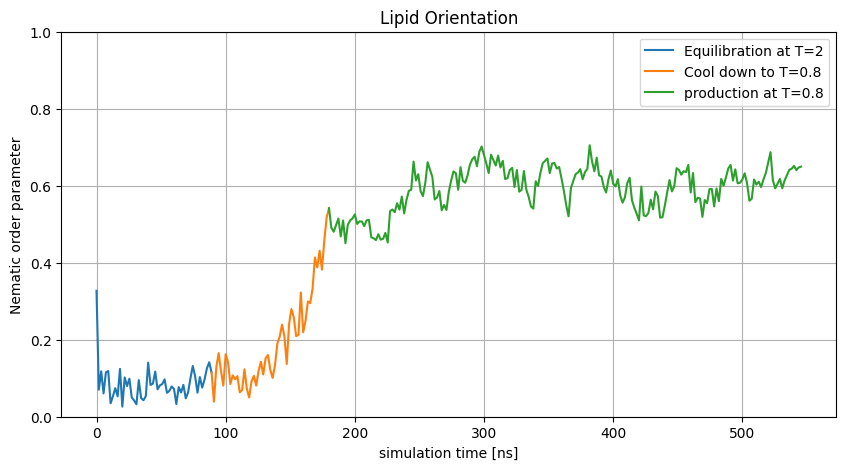

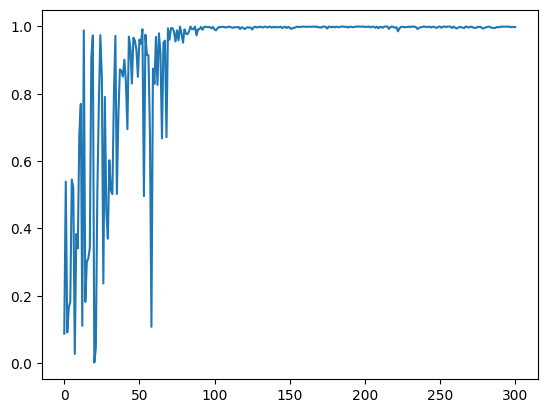

In [111]:
plt.figure(figsize=(10,5))

plt.plot(frame_axis[:high_temp]*time_per_frame,s_values[:high_temp], label="Equilibration at T=2")
plt.plot(frame_axis[high_temp-1:cool_down]*time_per_frame,s_values[high_temp-1:cool_down], label="Cool down to T=0.8")
plt.plot(frame_axis[cool_down-1:]*time_per_frame,s_values[cool_down-1:], label="production at T=0.8")


plt.ylim((0,1))
plt.xlabel("simulation time [ns]")
plt.ylabel("Nematic order parameter")
plt.title("Lipid Orientation")

plt.grid()
plt.legend()
plt.show()

plt.plot(np.abs(directors[:,2]))

## Density profile

In [89]:
def mol_proj_per_beadgroup(molecule, director, lst_heads, lst_links, lst_tails, lst_terminal, lst_mean_head):

    positions = molecule.atoms.positions

    tmp = []
    for j in [0,1]:
        proj = np.dot(positions[j], director)
        lst_heads.append(proj)
        tmp.append(proj)
    
    lst_mean_head.append(np.mean(tmp))

    for j in [2,3]:
        proj = np.dot(positions[j], director)
        lst_links.append(proj)

    for j in [4,5,6,8,9,10]:
        proj = np.dot(positions[j], director)
        lst_tails.append(proj)

    for j in [7,11]:
        proj = np.dot(positions[j], director)
        lst_terminal.append(proj)

In [90]:
def center_lst_values(lst1, lst2, lst3, lst4):

    lst1, lst2, lst3, lst4 = np.array(lst1), np.array(lst2), np.array(lst3), np.array(lst4)

    full_lst = np.concatenate([lst1, lst2, lst3, lst4])

    center = np.mean(full_lst)

    lst1 -= center
    lst2 -= center
    lst3 -= center
    lst4 -= center

    return lst1, lst2, lst3, lst4, center

In [91]:
def filter_tails(lst_mean_head, lst_terminal):

    for lipid_id in range(len(lst_mean_head)):

        start = 2*lipid_id
        end = 2*lipid_id + 2
        lipid_terminal = lst_terminal[start:end]

        left_terminal = []
        right_terminal = []

        if lst_mean_head[lipid_id] < 0:
            left_terminal.append(lipid_terminal)
        else:
            right_terminal.append(lipid_terminal)

        return left_terminal, right_terminal

In [92]:
def make_bins(lsts, n_bins):

    full_lst = []

    for lst in lsts:
        full_lst = np.concatenate([full_lst,lst])

    full_lst = np.array(full_lst) - np.mean(full_lst)

    min, max = np.percentile(full_lst, [1,99])
    min, max = min-1, max-1

    bins = np.linspace(min, max, n_bins+1)
    bin_centers = (bins[:-1] + bins[1:])/2
    bin_width = bins[1] - bins[0]

    return bins, bin_centers, bin_width

In [ ]:
def density_profile(universe, frame_start, directors, n_bins):

    proj_heads = []
    proj_links = []
    proj_tails = []
    proj_terminal = []

    proj_heads_per_lipid = []

    directors = np.abs(directors)

    lipid_res = universe.residues[:lipids]

    for frame_id, frame in enumerate(universe.trajectory[frame_start:], frame_start):

        director = directors[frame_id]
        box_dims = universe.dimensions[:3]

        coms = np.array([mol.atoms.center_of_mass() for mol in frame])
        projs_com = np.dot(director, coms)
        bilayer_center = np.mean(projs_com)

        shift = -bilayer_center

        for mol in lipid_res:

            mol_proj_per_beadgroup(mol, director, proj_heads, proj_links, proj_tails, proj_terminal, proj_heads_per_lipid)

    proj_heads, proj_links, proj_tails, proj_terminal, center = center_lst_values(proj_heads, proj_links, proj_tails, proj_terminal)
    proj_heads_per_lipid = np.array(proj_heads_per_lipid) - center

    left_terminal, right_terminal = filter_tails(proj_heads_per_lipid, proj_terminal)
    
    bins, bin_centers, bin_width = make_bins([proj_heads, proj_links, proj_tails, proj_terminal], n_bins)

    hist_heads, _ = np.histogram(proj_heads, bins=bins)
    hist_links, _ = np.histogram(proj_links, bins=bins)
    hist_tails, _ = np.histogram(proj_tails, bins=bins)
    hist_terminal, _ = np.histogram(proj_terminal, bins=bins)

    area = square_area(box_dims)
    bin_vol = area*bin_width
    n_frames = frames - frame_start

    hist_heads = hist_heads / (bin_vol * n_frames)
    hist_links = hist_links / (bin_vol * n_frames)
    hist_tails = hist_tails / (bin_vol * n_frames)
    hist_terminal = hist_terminal / (bin_vol * n_frames)

    return bin_centers, hist_heads, hist_links, hist_tails, hist_terminal

    


In [116]:
bin_centers, hist_heads, hist_links,hist_tails, hist_terminal = density_profile(u, 200, directors, 150)

In [95]:
a = np.array([1,2])
b = np.array([3,4])
c = np.array([5,6])

np.concatenate([a,[]])

array([1., 2.])

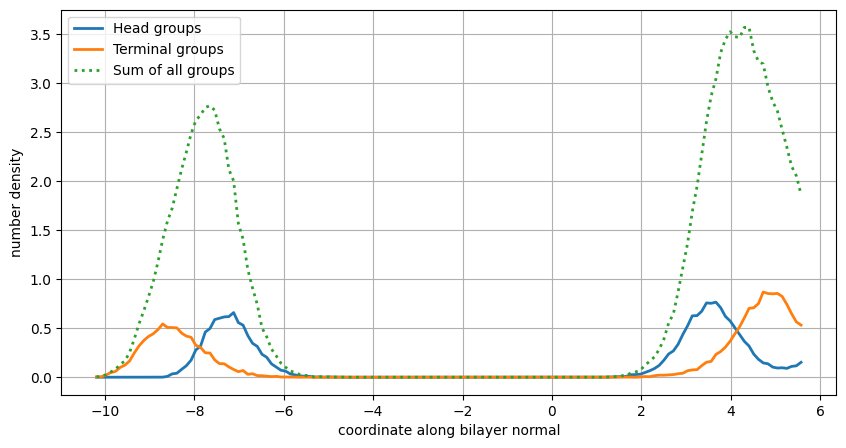

In [114]:
plt.figure(figsize=(10,5))

plt.plot(bin_centers, hist_heads, label='Head groups', linewidth=2)
#plt.plot(bin_centers, links, label='Link groups', linewidth=2)
#plt.plot(bin_centers, tails, label='Tail groups', linewidth=2)
plt.plot(bin_centers, hist_terminal, label='Terminal groups', linewidth=2)
plt.plot(bin_centers, hist_heads+hist_links+hist_tails+hist_terminal, label="Sum of all groups", linewidth=2, linestyle="dotted")
plt.xlabel("coordinate along bilayer normal")
plt.ylabel("number density")

plt.grid()
plt.legend()
plt.show()